In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

In [20]:
# ---------- 全域變數 ------------ #
DIR_INPUT = 'C:/teeth6/300' # 原始資料夾路徑
PIXEL_THRESHOLD = 2000  # 設定閾值，僅保留像素數大於該值的區域
AREA_THRESHOLD = 500 # 設定閾值，避免過小的分割區域
DISTANCE_THRESHOLD = 200 # 定義距離閾值（例如：設定 10 為最大可接受距離）
SHORT_SIDE = 120 # 轉動短邊判斷閾值
TWO_POINT_TEETH_THRESHOLD = 259 # 初判單雙牙尖使用
RANGE_FOR_TOOTH_TIP_LEFT = 80 # 強迫判斷雙牙尖，中心區域定義使用(左)
RANGE_FOR_TOOTH_TIP_RIGHT = 40 # 強迫判斷雙牙尖，中心區域定義使用(右)

In [21]:
# ---------- 函式定義 ------------ #
# 計算基於 ['enamel_x'] 和 ['enamel_y'] 的距離函數
def calculate_distance(row_true, row_cleaned):
    true_values = np.array([row_true['珐瑯質跟象牙質交接點x'], row_true['珐瑯質跟象牙質交接點y']])
    cleaned_values = np.array([row_cleaned['enamel_x'], row_cleaned['enamel_y']])
    return np.linalg.norm(true_values - cleaned_values)

# 根據 mask 判斷轉正使用的旋轉角度
def get_rotation_angle(mask):
    # 找輪廓
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0
    cnt = contours[0]

    # 根據輪廓取得方框
    rect = cv2.minAreaRect(cnt)
    angle = rect[2]

    # 牙齒長邊在左右兩側，確保長邊是垂直於水平線
    if rect[1][0] > rect[1][1]:
        angle += 90
    if angle > 90:
        angle += 180
    return angle

# 利用 cv2 進行轉動
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # 建立轉移角度用矩陣
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # 利用建立的矩陣進行轉移轉動
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

# 把指定座標轉移回去原圖角度
def convert_coord_back(coord, angle, image):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    
    # 建立轉移回原角度用矩陣
    M_inv = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    
    # 因為只轉動單座標，該轉移矩陣要有另一項進行矩陣運算，這裡放單位矩陣做運算配合用
    coord_ones = np.array([coord[0], coord[1], 1.0])
    
    # 轉回原先角度
    original_coord_back = M_inv.dot(coord_ones)
    
    # 取得原圖座標，並且轉為整數
    original_coord_back = original_coord_back[:2].astype(int)
    
    return original_coord_back

# 檢查數值是否在指定範圍中
def is_within_range(value, target, range_size=50):
    return target - range_size <= value <= target + range_size

def assign_non_none_values(dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y):
    # 檢查 dentin_left_x 和 dentin_right_x 是否只找到其中一邊，是則判定為單牙尖
    if dentin_left_x is None and dentin_right_x is not None:
        dentin_left_x = dentin_right_x
    elif dentin_right_x is None and dentin_left_x is not None:
        dentin_right_x = dentin_left_x

    # 檢查 dentin_left_y 和 dentin_right_y 是否存在，是則判定為單牙尖
    if dentin_left_y is None and dentin_right_y is not None:
        dentin_left_y = dentin_right_y
    elif dentin_right_y is None and dentin_left_y is not None:
        dentin_right_y = dentin_left_y

    return dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y

# 根據指定順序，照點座標高度(y座標)排序
def get_top_points(contours, reverse=True):
    all_points = []
    # 取得輪廓中所有點，並且放到同一 list
    for contour in contours:
        sorted_points = sorted(contour, key=lambda x: x[0][1], reverse=reverse)
        top_points = sorted_points
        all_points.extend(top_points)
    # 排序
    all_points = sorted(all_points, key=lambda x: x[0][1], reverse=reverse)
    return all_points

# 計算 true_stage 並轉換為毫米
def calculate_true_stage(row):
    enamel_x, enamel_y = row['珐瑯質跟象牙質交接點x'], row['珐瑯質跟象牙質交接點y']
    gum_x, gum_y = row['牙齦交接點x'], row['牙齦交接點y']
    dentin_x, dentin_y = row['牙本體尖端點x'], row['牙本體尖端點y']
    
    # 圖片比例轉換 (像素轉毫米)
    x_scale = 41 / 1280
    y_scale = 31 / 960

    # 將像素轉換為毫米座標
    enamel_x_mm = enamel_x * x_scale
    enamel_y_mm = enamel_y * y_scale
    gum_x_mm = gum_x * x_scale
    gum_y_mm = gum_y * y_scale
    dentin_x_mm = dentin_x * x_scale
    dentin_y_mm = dentin_y * y_scale
    
    # 計算距離 (毫米)
    CEJ_ALC = np.sqrt((enamel_x_mm - gum_x_mm) ** 2 + (enamel_y_mm - gum_y_mm) ** 2)
    CEJ_APEX = np.sqrt((enamel_x_mm - dentin_x_mm) ** 2 + (enamel_y_mm - dentin_y_mm) ** 2)
    
    # 計算 ABLD
    ABLD = ((CEJ_ALC - 2) / (CEJ_APEX - 2)) * 100
    
    # 判定 true_stage
    if ABLD <= 0:
        stage = "0"
    elif ABLD <= 15:
        stage = "I"
    elif ABLD <= 33.3:
        stage = "II"
    else:
        stage = "III"
    
    return stage
               
# 計算 predicted_stage 並轉換為毫米
def calculate_predicted_stage(row):
    enamel_x, enamel_y = row['enamel_x'], row['enamel_y']
    gum_x, gum_y = row['gum_x'], row['gum_y']
    dentin_x, dentin_y = row['dentin_x'], row['dentin_y']
    
    # 圖片比例轉換 (像素轉毫米)
    x_scale = 41 / 1280
    y_scale = 31 / 960

    # 將像素轉換為毫米座標
    enamel_x_mm = enamel_x * x_scale
    enamel_y_mm = enamel_y * y_scale
    gum_x_mm = gum_x * x_scale
    gum_y_mm = gum_y * y_scale
    dentin_x_mm = dentin_x * x_scale
    dentin_y_mm = dentin_y * y_scale
    
    # 計算距離 (毫米)
    CEJ_ALC = np.sqrt((enamel_x_mm - gum_x_mm) ** 2 + (enamel_y_mm - gum_y_mm) ** 2)
    CEJ_APEX = np.sqrt((enamel_x_mm - dentin_x_mm) ** 2 + (enamel_y_mm - dentin_y_mm) ** 2)
    
    # 計算 ABLD
    ABLD = ((CEJ_ALC - 2) / (CEJ_APEX - 2)) * 100
    
    # 判定 predicted_stage
    if ABLD <= 0:
        stage = "0"
    elif ABLD <= 15:
        stage = "I"
    elif ABLD <= 33.3:
        stage = "II"
    else:
        stage = "III"
    
    return ABLD, stage

In [22]:
# ---------- 影像處理與遮罩相關函式 ------------ #

def load_images_and_masks(dir_path, target_dir):
    """載入影像及其對應的遮罩"""
    paths = {
        'gum': f"gum_{target_dir}.png",
        'teeth': f"teeth_{target_dir}.png",
        'dental_crown': f"dentalcrown_{target_dir}.png",
        'crown': f"crown_{target_dir}.png",
        'dentin': f"dentin_{target_dir}.png",
        'original': f"raw_{target_dir}.png"
    }
    images = {name: cv2.imread(os.path.join(dir_path, path), cv2.IMREAD_GRAYSCALE if name != 'original' else cv2.IMREAD_COLOR) 
              for name, path in paths.items()}
    return images

def threshold_images(images):
    """將影像轉為二值圖"""
    binary_images = {}
    for key, img in images.items():
        if key != 'original':
            _, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
            binary_images[key] = binary_img
    return binary_images

def clean_mask(mask, kernel_size=(3, 3), iterations=5):
    """清理影像中的雜點"""
    kernel = np.ones(kernel_size, np.uint8)
    mask = cv2.erode(mask, kernel, iterations=iterations)
    mask = cv2.dilate(mask, kernel, iterations=iterations)
    return mask

def filter_large_components(mask, pixel_threshold):
    """過濾掉像素數量小於閾值的區域"""
    num_labels, labels = cv2.connectedComponents(mask)
    label_counts = np.bincount(labels.flatten())
    filtered_image = np.zeros_like(mask)
    for label in range(1, num_labels):
        if label_counts[label] > pixel_threshold:
            filtered_image[labels == label] = 255
    return filtered_image

In [23]:
# ---------- 影像分析與特徵提取相關函式 ------------ #

def extract_features(binary_images, original_img):
    """從遮罩中提取特徵點與區域資訊"""
    overlay = original_img.copy()
    line_image = original_img.copy()
    kernel = np.ones((3, 3), np.uint8)

    # 清理各個遮罩
    binary_images['dental_crown'] = clean_mask(binary_images['dental_crown'])
    binary_images['dentin'] = clean_mask(binary_images['dentin'], kernel_size=(30, 1), iterations=1)
    # binary_images['gum'] = clean_mask(binary_images['gum'], kernel_size=(30, 1), iterations=2)

    # 保留最大區域
    binary_images['gum'] = extract_largest_component(binary_images['gum'])

    # 膨脹處理後的 gum
    dilated_gum = cv2.dilate(binary_images['gum'], kernel, iterations=10)

    # 合併所有遮罩
    combined_mask = combine_masks(dilated_gum, binary_images)
    non_masked_area = cv2.bitwise_not(combined_mask)

     # 繪製 overlay
    overlay[binary_images["dental_crown"] > 0] = (163, 118, 158)  # 將 dental_crown 顯示
    overlay[binary_images["dentin"] > 0] = (117, 122, 152)  # 將 dentin 顯示
    overlay[binary_images['gum'] > 0] = (0, 177, 177)  # 將 dentin 顯示
    overlay[binary_images['crown'] > 0] = (255, 0, 128) # 將 crown 顯示

    # 回傳疊加後的影像和線條影像
    return overlay, line_image, non_masked_area

def extract_largest_component(mask):
    """提取遮罩中的最大連通區域"""
    num_labels, labels = cv2.connectedComponents(mask)
    label_counts = np.bincount(labels.flatten())
    max_label = np.argmax(label_counts[1:]) + 1
    largest_component = np.zeros_like(mask)
    largest_component[labels == max_label] = 255
    return largest_component

def combine_masks(gum_mask, binary_images):
    """合併所有遮罩，形成完整的合併遮罩"""
    combined_mask = cv2.bitwise_or(gum_mask, binary_images['teeth'])
    combined_mask = cv2.bitwise_or(combined_mask, binary_images['dental_crown'])
    combined_mask = cv2.bitwise_or(combined_mask, binary_images['dentin'])
    return combined_mask

In [24]:
# ---------- 點座標分析相關函式 ------------ #

def less_than_area_threshold(component_mask, area_threshold):
    """根據指定面積大小，過濾過小的分割區域"""
    area = cv2.countNonZero(component_mask)
    # 去除掉過小的分割區域
    if area < area_threshold:
        return True
    return False

def get_mid_point(image, dilated_mask, idx):
    """取得物件中點，並且繪製點及idx標籤於 image"""
    non_zero_points = np.column_stack(np.where(dilated_mask > 0))
    if len(non_zero_points) > 0:
        mid_point = np.mean(non_zero_points, axis=0).astype(int)
        mid_y, mid_x = mid_point
        # 在繪製用圖片標註 dentin 中心點及對應數字標籤
        cv2.putText(image, str(idx), (mid_x-5, mid_y-5), cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 0), 1, cv2.LINE_AA)
        cv2.circle(image, (mid_x, mid_y), 5, (255, 255, 0), -1)  # 黃色圓點
    return mid_y, mid_x

def locate_points_with_dental_crown(dental_crown_bin, dilated_mask, mid_x, mid_y, overlay):
    """處理與 dental_crown 之交點 (Enamel的底端)"""
    # 獲取每個獨立 mask 與原始 mask 的交集區域
    intersection = cv2.bitwise_and(dental_crown_bin, dilated_mask)
    overlay[intersection > 0] = (255, 0, 0)  # 將 dentin 顯示
    # 取得交集區域的 contour 作為交點
    contours, _ = cv2.findContours(intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None, None, None, None
    # 將交點進行排序
    corners = get_top_points(contours, reverse=True)
    # 確認排序成功成功
    if corners is not None:
        # 整數化
        corners = np.int32(corners)
        # 初始化取得座標，預設左右兩邊皆有
        enamel_left_x = None
        enamel_left_y = None
        enamel_right_x = None
        enamel_right_y = None
        # 針對每個點進行處理
        for corner in corners:
            # 取得交點座標
            x, y = corner.ravel()
            # 判斷左右
            if x < mid_x:
                # 後續判斷
                if enamel_left_x is not None:
                    # 找到 y 最大者
                    if y > enamel_left_y:
                        enamel_left_x = x
                        enamel_left_y = y
                        continue
                    # 因以排序，看到 x 座標過接近的交點就不要重複看
                    elif is_within_range(x, enamel_left_x):
                        continue
                # 初判
                else:
                    enamel_left_x = x
                    enamel_left_y = y
            elif x > mid_x:
                # 後續判斷
                if enamel_right_x is not None:
                    # 找到 y 最大者
                    if y > enamel_right_y:
                        enamel_right_x = x
                        enamel_right_y = y
                        continue
                    # 因以排序，看到 x 座標過接近的交點就不要重複看
                    elif is_within_range(x, enamel_right_x):
                        continue
                # 初判
                else:
                    enamel_right_x = x
                    enamel_right_y = y
    return enamel_left_x, enamel_left_y, enamel_right_x, enamel_right_y

def locate_points_with_gum(gum_bin, dilated_mask, mid_x, mid_y, overlay):
    """處理與 gum 之交點 (Alveolar_bone的頂端)"""
    # 獲取每個獨立 mask 與原始 mask 的交集區域
    intersection = cv2.bitwise_and(gum_bin, dilated_mask)
    overlay[intersection > 0] = (0, 255, 0)  # 將 dentin 顯示
    # 取得交集區域的 contour 作為交點
    contours, _ = cv2.findContours(intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None, None, None, None
    # 反向排序
    corners = get_top_points(contours, reverse=False) #  
    # 確認排序成功
    if corners is not None:
        # 整數化
        top_corners = np.int32(corners)  
        # 初始化取得座標，預設左右兩邊皆有
        gum_left_x = None
        gum_left_y = None
        gum_right_x = None
        gum_right_y = None
        # 針對每個點進行處理
        for corner in top_corners:
            # 取得交點座標
            x, y = corner.ravel()
            # 如果該交點超出中心點太多，就過濾掉
            if x >= mid_x-40 and x <= mid_x+40:
                continue
            # 判斷左右
            if x < mid_x:
                # 後續判斷
                if gum_left_x is not None:
                    # 找到 y 最小者
                    if y < gum_left_y:
                        gum_left_x = x
                        gum_left_y = y
                        continue
                    # 因以排序，看到 x 座標過接近的交點就不要重複看
                    elif is_within_range(x, gum_left_x):
                        continue
                # 初判
                else:
                    gum_left_x = x
                    gum_left_y = y
            elif x > mid_x:
                # 後續判斷
                if gum_right_x is not None:
                    # 找到 y 最小者
                    if y < gum_right_y:
                        gum_right_x = x
                        gum_right_y = y
                        continue
                    # 因以排序，看到 x 座標過接近的交點就不要重複看
                    elif is_within_range(x, gum_right_x):
                        continue
                # 初判
                else:
                    gum_right_x = x
                    gum_right_y = y
    return gum_left_x, gum_left_y, gum_right_x, gum_right_y

def locate_points_with_dentin(gum_bin, dilated_mask, mid_x, mid_y, angle ,short_side, image, component_mask):
    # 取得 dentin 與 gum 交集
    intersection = cv2.bitwise_and(gum_bin, dilated_mask)
    # 由於希望取得 dentin 與 gum 交集的底部，所以需要轉正
    # 建立旋轉後的 mask 和 繪製用圖片
    c_image = rotate_image(image, angle)
    c_intersection = rotate_image(intersection, angle)
    c_dilated_mask = rotate_image(dilated_mask, angle)
    # 取得旋轉後區域的中點
    non_zero_points = np.column_stack(np.where(c_dilated_mask > 0))
    if len(non_zero_points) > 0:
        mid_point = np.mean(non_zero_points, axis=0).astype(int)
        c_mid_y, c_mid_x = mid_point
    # 初始化取得座標，預設左右兩邊皆有        
    dentin_left_x = None
    dentin_left_y = None
    dentin_right_x = None
    dentin_right_y = None
    # 根據短邊大小(寬度)，初步判斷單牙尖或雙牙尖
    if short_side > TWO_POINT_TEETH_THRESHOLD:
        # 較寬者，強迫判斷為雙牙尖
        contours, _ = cv2.findContours(c_intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return None, None, None, None
        top_points = get_top_points(contours, reverse=True)
        bottom_corners = top_points
        # 初始化左右兩邊的點列表
        left_corners = []
        right_corners = []
        # 根據 c_mid_x 分配點到左右兩邊
        for point in bottom_corners:
            x, y = point.ravel() # 取得左右兩邊
            if x < c_mid_x-RANGE_FOR_TOOTH_TIP_LEFT:
                left_corners.append(point)
            # 雙牙尖，太中間的點不可能是牙尖
            elif x >= c_mid_x-RANGE_FOR_TOOTH_TIP_LEFT and x <= c_mid_x+RANGE_FOR_TOOTH_TIP_RIGHT:
                continue
            else:
                right_corners.append(point)
        # 左牙尖判斷
        for corner in left_corners:
            # 取得點座標
            x, y = corner.ravel()
            # 確定為左邊
            if x < c_mid_x:
                # 後續判斷
                if dentin_left_x is not None:
                    # 取得 y 最大者
                    if y > dentin_left_y:
                        dentin_left_x = x
                        dentin_left_y = y
                        continue
                # 初判
                else:
                    dentin_left_x = x
                    dentin_left_y = y
        # 右牙尖判斷
        for corner in right_corners:
            # 取得點座標
            x, y = corner.ravel()
            # 確定為右邊
            if x > c_mid_x:
                # 後續判斷
                if dentin_right_x is not None:
                    # 取得 y 最大者
                    if y > dentin_right_y:
                        dentin_right_x = x
                        dentin_right_y = y
                        continue
                # 初判
                else:
                    dentin_right_x = x
                    dentin_right_y = y
        # 避免 None 存在，因有可能在上述流程誤判為雙牙尖
        dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y = assign_non_none_values(dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y)
        #---- 例外狀況 ---- 左右牙尖高度落差較大
        print("Debugging ::")
        if all(v is None for v in [dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y]):
            print("All variables are None.")
        else:
            if not is_within_range(dentin_left_y, dentin_right_y, 200):
                if dentin_right_y > dentin_left_y:
                    dentin_left_y = dentin_right_y
                    dentin_left_x = dentin_right_x
                else:
                    dentin_right_y = dentin_left_y
                    dentin_right_x = dentin_left_x
    else:
        # 進行交點搜尋
        contours, _ = cv2.findContours(c_intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return None, None, None, None
        # 排序
        bottom_corners = get_top_points(contours, reverse=True)
        for corner in bottom_corners:
            x, y = corner.ravel()
            # 判斷左右邊(預設是雙牙尖)
            if x < c_mid_x:
                # 後續判斷
                if dentin_left_x is not None:
                    # 取得 y 最大者
                    if y > dentin_left_y:
                        dentin_left_x = x
                        dentin_left_y = y
                        continue
                # 初判
                else:
                    dentin_left_x = x
                    dentin_left_y = y
            elif x > c_mid_x:
                # 後續判斷
                if dentin_right_x is not None:
                    # 取得 y 最大者
                    if y > dentin_right_y:
                        dentin_right_x = x
                        dentin_right_y = y
                        continue
                # 初判
                else:
                    dentin_right_x = x
                    dentin_right_y = y
         # 避免 None 存在，因有可能在上述流程誤判為雙牙尖
        dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y = assign_non_none_values(dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y)
        # 如果判斷出來的雙邊牙尖過於接近，確定應為單牙尖狀況，故指定最小者為牙尖
        if is_within_range(dentin_left_x, dentin_right_x, 80):
            bottom_corner = bottom_corners[:1]
            for corner in bottom_corner:
                x, y = corner.ravel()
                dentin_left_x = x
                dentin_left_y = y
                dentin_right_x = x
                dentin_right_y = y
                cv2.circle(c_image, (x, y), 5, (255, 0, 0), -1)
    
    # 將旋轉後的座標，轉回原角度
    dentin_left_coord = [dentin_left_x, dentin_left_y]
    dentin_right_coord = [dentin_right_x, dentin_right_y]
    dentin_left_x, dentin_left_y = convert_coord_back(dentin_left_coord, angle, component_mask)
    dentin_right_x, dentin_right_y = convert_coord_back(dentin_right_coord, angle, component_mask)
    
    # 膨脹避免資訊被截斷(旋轉回去有可能截到)
    kernel = np.ones((3, 3), np.uint8)
    c_dilated_mask = cv2.dilate(c_dilated_mask, kernel, iterations=5)
    c_dilated_mask_rotated_back = rotate_image(c_dilated_mask, -angle)
    c_image_rotated_back = rotate_image(c_image, -angle)
    mask = c_dilated_mask_rotated_back > 0
    # 把對應區域放回去原圖
    image[mask] = c_image_rotated_back[mask]
    
    return dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y

# 輸入為繪圖用圖片 image, 獨立的 dentin 的分割區域 component_mask
def locate_points(image, component_mask, binary_images, idx, overlay):
    """以分割後的 dentin 為單位進行處理"""
    prediction = {}
    if less_than_area_threshold(component_mask, AREA_THRESHOLD):
        return prediction
    # 以方框框住該 component_mask，整數化
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rect = cv2.minAreaRect(contours[0]) # 最小區域長方形
    box = cv2.boxPoints(rect) # 取得長方形座標
    box = np.int32(box) # 整數化 
    width = rect[1][0]  # 寬度
    height = rect[1][1]  # 高度
    short_side = min(width, height)  # 短邊
    long_side = max(width, height)
    if short_side < SHORT_SIDE:
       return prediction
    
    # 判斷旋轉角度
    angle = get_rotation_angle(component_mask)
    # 如果長短邊差距在 30 內 (接近正方形)，不轉動
    if is_within_range(short_side, long_side, 30):
        angle = 0
        
    # 膨脹獨立 dentin 分割區域
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask = cv2.dilate(component_mask, kernel, iterations=7)
 
    # 取得中點
    mid_y, mid_x = get_mid_point(image, dilated_mask, idx)

    ########### 處理與 dental_crown 之交點 (Enamel的底端) ########### 
    enamel_left_x, enamel_left_y, enamel_right_x, enamel_right_y = locate_points_with_dental_crown(binary_images["dental_crown"], dilated_mask, mid_x, mid_y, overlay)
    ########### 處理與 gum 之交點 (Alveolar_bone的頂端) ########### 
    gum_left_x, gum_left_y, gum_right_x, gum_right_y = locate_points_with_gum(binary_images["gum"], dilated_mask, mid_x, mid_y, overlay)
    ########### 處理與 dentin 的底端 ########### 
    dentin_left_x, dentin_left_y, dentin_right_x, dentin_right_y = locate_points_with_dentin(binary_images["gum"], dilated_mask, mid_x, mid_y, angle, short_side, image, component_mask)
    
    prediction = {"mid": (mid_x, mid_y), 
                "enamel_left": (enamel_left_x, enamel_left_y), "enamel_right":(enamel_right_x, enamel_right_y),
                "gum_left":(gum_left_x, gum_left_y), "gum_right": (gum_right_x, gum_right_y),
                "dentin_left":(dentin_left_x, dentin_left_y), "dentin_right":(dentin_right_x, dentin_right_y),
                }
    return prediction
 
def draw_image_and_print_information(prediction, image_for_drawing, line_image):
    # 繪圖及印出資訊
    print("Mid Points : ", prediction["mid"])
    print("enamel_left : ", prediction["enamel_left"])
    print("enamel_right : ", prediction["enamel_right"])
    print("gum_left : ", prediction["gum_left"])
    print("gum_right : ", prediction["gum_right"])
    print("dentin_left : ", prediction["dentin_left"])
    print("dentin_right : ", prediction["dentin_right"])
    cv2.circle(image_for_drawing, prediction["enamel_left"], 5, (0, 0, 255), -1)
    cv2.circle(image_for_drawing, prediction["enamel_right"], 5, (0, 0, 255), -1)
    cv2.circle(image_for_drawing, prediction["gum_left"], 5, (0, 255, 0), -1)
    cv2.circle(image_for_drawing, prediction["gum_right"], 5, (0, 255, 0), -1)
    cv2.circle(image_for_drawing, prediction["dentin_left"], 5, (255, 0, 0), -1)
    cv2.circle(image_for_drawing, prediction["dentin_right"], 5, (255, 0, 0), -1)
    # Draw lines between points
    print("e_l -> d_l : ", prediction["enamel_left"], prediction["dentin_left"])
    if (prediction["enamel_left"][0] is not None) and (prediction["dentin_left"] is not None):
        cv2.line(line_image, prediction["enamel_left"], prediction["dentin_left"], (0, 0, 255), 2)
    else:
        print("None Detected. Not drawing line.")
        
    print("e_l -> g_l : ", prediction["enamel_left"], prediction["gum_left"])
    if (prediction["enamel_left"][0] is not None) and (prediction["gum_left"][0] is not None):
        cv2.line(line_image, prediction["enamel_left"], prediction["gum_left"], (0, 255, 255), 2)
    else:
        print("None Detected. Not drawing line.")
        
    print("e_r -> d_r : ", prediction["enamel_right"], prediction["dentin_right"])
    if (prediction["enamel_right"][0] is not None) and (prediction["dentin_right"] is not None):
        cv2.line(line_image, prediction["enamel_right"], prediction["dentin_right"], (0, 0, 255), 2)
    else:
        print("None Detected. Not drawing line.")
    
    print("e_r -> g_r : ", prediction["enamel_right"], prediction["gum_right"])
    if (prediction["enamel_right"][0] is not None) and (prediction["gum_right"][0] is not None):
        cv2.line(line_image, prediction["enamel_right"], prediction["gum_right"], (0, 255, 255), 2)
    else:
        print("None Detected. Not drawing line.")

In [25]:
# ---------- 資料處理與儲存相關函式 ------------ #

def process_and_save_predictions(predictions, dir_path, target_dir, correct_df):
    """處理並儲存預測結果"""
    sorted_predictions = sorted(predictions, key=lambda x: x['mid'][0])
    df = pd.DataFrame(sorted_predictions)
    
    if len(df) == 0:
        df = correct_df.drop(index=df.index)
        df.to_excel(os.path.join(dir_path, f"{target_dir}_comparison_results.xlsx"), index=False)
        return

    df = restructure_dataframe(df)
    df_combined = combine_and_clean_dataframe(df)

    # 儲存合併結果
    df_cleaned = df_combined.dropna()
    if len(df_cleaned) != 0:
        df_cleaned['percentage'], df_cleaned['predicted_stage'] = zip(*df_cleaned.apply(calculate_predicted_stage, axis=1)) # 計算 stage
    df_true_cleaned = prepare_true_dataframe(correct_df)

    df_merged = merge_dataframes(df_cleaned, df_true_cleaned)
    df_merged = df_merged.rename(columns={'牙齒ID（相對該張影像的順序ID即可、從左至右）':'tooth_id', 
                        "牙尖ID（從左側至右側，看是連線到哪一個牙尖端）":"dentin_id",
                        "珐瑯質跟象牙質交接點x":"enamel_x", "珐瑯質跟象牙質交接點y":"enamel_y",
                        "牙齦交接點x":"gum_x" , "牙齦交接點y":"gum_y",
                        "牙本體尖端點x":"dentin_x" , "牙本體尖端點y":"dentin_y" ,
                        "長度":"length","stage":"true_stage"
                        })
    df_merged.to_excel(os.path.join(dir_path, f"{target_dir}_comparison_results.xlsx"), index=False)

def restructure_dataframe(df):
    """重構 DataFrame 結構"""
    df = df.drop(columns=['dentin_id'])
    df['tooth_id'] = range(1, len(df) + 1)
    df_left = df[['tooth_id', 'mid', 'enamel_left', 'gum_left', 'dentin_left']]
    df_left.columns = ['tooth_id', 'mid', 'enamel', 'gum', 'dentin']
    df_right = df[['tooth_id', 'mid', 'enamel_right', 'gum_right', 'dentin_right']]
    df_right.columns = ['tooth_id', 'mid', 'enamel', 'gum', 'dentin']
    return pd.concat([df_left, df_right]).sort_values(by=['tooth_id', 'enamel']).reset_index(drop=True)

def combine_and_clean_dataframe(df_combined):
    """合併 DataFrame 並清理資料"""
    dentin_id = 1
    dentin_ids = [dentin_id]
    for i in range(1, len(df_combined)):
        if df_combined.iloc[i]['dentin'] == df_combined.iloc[i - 1]['dentin']:
            dentin_ids.append(dentin_id)
        else:
            dentin_id += 1
            dentin_ids.append(dentin_id)

    df_combined['dentin_id'] = dentin_ids
    df_combined[['enamel_x', 'enamel_y']] = pd.DataFrame(df_combined['enamel'].tolist(), index=df_combined.index)
    df_combined[['gum_x', 'gum_y']] = pd.DataFrame(df_combined['gum'].tolist(), index=df_combined.index)
    df_combined[['dentin_x', 'dentin_y']] = pd.DataFrame(df_combined['dentin'].tolist(), index=df_combined.index)
    return df_combined.drop(columns=['mid', 'enamel', 'gum', 'dentin'])

def prepare_true_dataframe(correct_df):
    """準備真實資料的 DataFrame"""
    df_true_cleaned = correct_df
    df_true_cleaned = correct_df.drop(columns=['長度', 'stage'])
    #df_true_cleaned = correct_df.rename(columns={'珐瑯質跟象牙質交接點x':'enamel_x', "珐瑯質跟象牙質交接點y":"enamel_y"})
    df_true_cleaned['true_stage'] = df_true_cleaned.apply(calculate_true_stage, axis=1)
    return df_true_cleaned

def merge_dataframes(df_cleaned, df_true_cleaned):
    """合併預測資料與真實資料"""
    df_merged_list = []
    for index, row_true in df_true_cleaned.iterrows():
        if df_cleaned.empty:
            row_true_reset = df_true_cleaned.iloc[[index]].reset_index(drop=True)
            #row_true_reset.loc[0, ['class', 'denture']] = np.nan
            empty_predicted_columns = pd.DataFrame(np.nan, index=row_true_reset.index, columns=df_cleaned.columns)
            merged_row = pd.concat([row_true_reset, empty_predicted_columns], axis=1)
        else:
            distances = df_cleaned.apply(lambda row_cleaned: calculate_distance(row_true, row_cleaned), axis=1)
            closest_index = distances.idxmin()
            min_distance = distances[closest_index]

            if min_distance > DISTANCE_THRESHOLD:
                row_true_reset = df_true_cleaned.iloc[[index]].reset_index(drop=True)
                #row_true_reset.loc[0, ['class', 'denture']] = np.nan
                print(row_true_reset)
                empty_predicted_columns = pd.DataFrame(np.nan, index=row_true_reset.index, columns=df_cleaned.columns)
                merged_row = pd.concat([row_true_reset, empty_predicted_columns], axis=1).reset_index(drop=True)
            else:
                row_true_reset = df_true_cleaned.iloc[[index]].reset_index(drop=True)
                row_cleaned_reset = df_cleaned.loc[[closest_index]].reset_index(drop=True)
                merged_row = pd.concat([row_true_reset, row_cleaned_reset], axis=1).reset_index(drop=True)
                df_cleaned = df_cleaned.drop(closest_index)

        df_merged_list.append(merged_row)
    return pd.concat(df_merged_list, ignore_index=True)

In [ ]:
# ---------- 主程式入口 ------------ #

def main():
    dir_list = os.listdir(DIR_INPUT)
    
    # 針對每個資料夾進行處理
    for target_dir in dir_list:
        predictions = []
        dir_path = os.path.join(DIR_INPUT, target_dir)
        # 掃視該資料夾內部，若不是資料夾則不進行處理
        if not os.path.isdir(dir_path):
            continue
        
        # 批量讀入圖片，並且以字典定義
        images = load_images_and_masks(dir_path, target_dir)
        # 複製一個繪圖用圖片
        image_for_drawing = images["original"].copy()
        # 批量二值化圖片，並且以字典定義
        binary_images = threshold_images(images)
        
        # 處理繪圖用圖片等特徵處理後圖片
        overlay, line_image, non_masked_area = extract_features(binary_images, images['original'])
        
        # 取得分割開的 dentin , num_labels 表示 lables 數量， labels 則是分割對應
        num_labels, labels = cv2.connectedComponents(binary_images['dentin'])
        # 針對獨立分割 dentin 個別處理
        for i in range(1, num_labels):  # 從1開始，0是背景
            component_mask = np.uint8(labels == i) * 255
            # 取得分析後的點
            prediction = locate_points(image_for_drawing, component_mask, binary_images, i, overlay)
            # 如果無法判斷點，會回傳空字典
            if len(prediction) == 0:
                continue
            prediction["tooth_id"] = i
            prediction["dentin_id"] = None
            predictions.append(prediction)
            print(f"Tooth {i}")
            draw_image_and_print_information(prediction, image_for_drawing, line_image)
        
        cv2.addWeighted(overlay, 0.3, image_for_drawing, 0.7, 0, image_for_drawing)
        # 存繪製後的圖
        cv2.imwrite(os.path.join(dir_path, f'output_{target_dir}.png'), image_for_drawing)
        cv2.imwrite(os.path.join(dir_path, f'output_line_{target_dir}.png'), line_image)
        # 讀取正解 df
        correct_df = pd.read_excel(os.path.join(dir_path, f"analysis_{target_dir}.xlsx"))

        process_and_save_predictions(predictions, dir_path, target_dir, correct_df)

if __name__ == "__main__":
    main()

Skipping 100_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 105_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 109_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 110_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 131_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 141_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 163_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 170_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 193_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 197_comparison_results.xlsx: 'predicted_stage', 'class', or 'denture' column not found.
Skipping 202_comparison_result

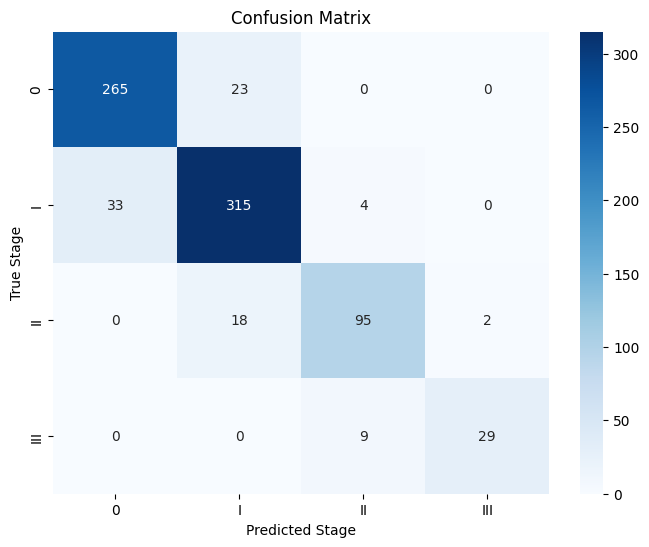


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       288
           I       0.88      0.89      0.89       352
          II       0.88      0.83      0.85       115
         III       0.94      0.76      0.84        38

    accuracy                           0.89       793
   macro avg       0.90      0.85      0.87       793
weighted avg       0.89      0.89      0.89       793


AUC (Area Under the Curve): 0.9030162499584958


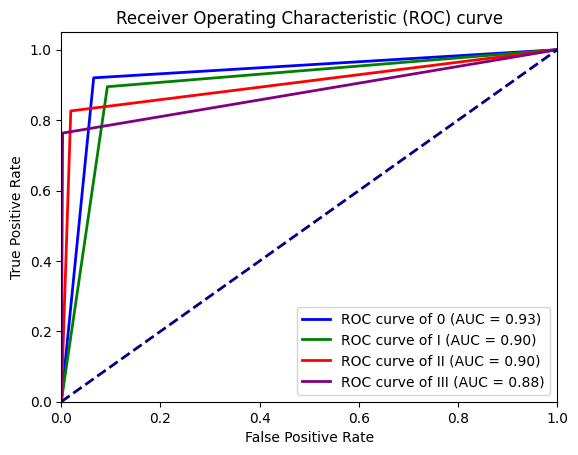

In [11]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# 設定主資料夾路徑
main_folder_path = r'C:\teeth6\300'

# 初始化空的 DataFrame 來儲存篩選後的結果
filtered_data = pd.DataFrame()

# 定義分期對應
stage_mapping = {'0': 0, 'I': 1, 'II': 2, 'III': 3}
reverse_stage_mapping = {v: k for k, v in stage_mapping.items()}

# 遍歷所有子資料夾
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # 確保當前處理的是資料夾
    if os.path.isdir(folder_path):
        file_name = f"{folder_name}_comparison_results.xlsx"
        file_path = os.path.join(folder_path, file_name)

        if os.path.exists(file_path):
            df = pd.read_excel(file_path)

            # 將所有欄位名稱轉為小寫並去掉前後空白，確保欄位名一致性
            df.columns = df.columns.str.strip().str.lower()

            # 確認 'predicted_stage' 和 'class' 是否存在，否則跳過該檔案
            if 'predicted_stage' in df.columns and 'class' in df.columns and 'denture' in df.columns:
                # 篩選 class 欄位為 0 且 denture 欄位為 0 的部分
                class_0_denture_0_data = df[(df['class'] == 0) & (df['denture'] == 0)]

                # 篩選 predicted_stage 有值的部分
                valid_data = class_0_denture_0_data.dropna(subset=['predicted_stage'])

                # 將篩選後的資料加入到 filtered_data 中
                filtered_data = pd.concat([filtered_data, valid_data], ignore_index=True)
            else:
                print(f"Skipping {file_name}: 'predicted_stage', 'class', or 'denture' column not found.")

# 檢查篩選後的資料
if not filtered_data.empty:
    print("Filtered Data: ")
    print(filtered_data.head())  # 顯示篩選後的前幾列資料

    # 映射前檢查 true_stage 和 predicted_stage 的唯一值
    print("Unique values in true_stage before mapping:", filtered_data['true_stage'].unique())
    print("Unique values in predicted_stage before mapping:", filtered_data['predicted_stage'].unique())

    # 將 true_stage 和 predicted_stage 中的分期轉換為整數
    filtered_data['true_stage'] = filtered_data['true_stage'].map(stage_mapping)
    filtered_data['predicted_stage'] = filtered_data['predicted_stage'].map(stage_mapping)

    # 檢查映射後的無效值
    invalid_true_stage = filtered_data[filtered_data['true_stage'].isna()]
    invalid_predicted_stage = filtered_data[filtered_data['predicted_stage'].isna()]

    if not invalid_true_stage.empty:
        print("Invalid true_stage values after mapping:")
        print(invalid_true_stage[['true_stage']].drop_duplicates())

    if not invalid_predicted_stage.empty:
        print("Invalid predicted_stage values after mapping:")
        print(invalid_predicted_stage[['predicted_stage']].drop_duplicates())

    # 移除轉換後仍然無效（無法匹配到分期）的資料
    filtered_data = filtered_data.dropna(subset=['predicted_stage', 'true_stage'])

    print("Filtered Data after conversion:")
    print(filtered_data.head())

    if not filtered_data.empty:
        # 計算 confusion matrix
        conf_matrix = confusion_matrix(filtered_data['true_stage'], filtered_data['predicted_stage'])
        print("Confusion Matrix:")
        print(conf_matrix)

        # 繪製 confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=list(stage_mapping.keys()), 
                    yticklabels=list(stage_mapping.keys()))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Stage')
        plt.ylabel('True Stage')
        plt.show()

        # 計算精度、精確率、召回率、F1分數
        report = classification_report(filtered_data['true_stage'], 
                                       filtered_data['predicted_stage'], 
                                       target_names=list(stage_mapping.keys()))
        print("\nClassification Report:")
        print(report)

        # 計算 AUC
        # 將類別標籤轉換為 one-hot 編碼
        true_stage_onehot = label_binarize(filtered_data['true_stage'], classes=[0, 1, 2, 3])
        predicted_stage_onehot = label_binarize(filtered_data['predicted_stage'], classes=[0, 1, 2, 3])

        # 計算每個類別的 AUC，使用 one-vs-one 方法
        auc = roc_auc_score(true_stage_onehot, predicted_stage_onehot, average="macro", multi_class="ovo")
        print(f"\nAUC (Area Under the Curve): {auc}")

        # 計算並繪製每個類別的 ROC 曲線
        fpr = {}
        tpr = {}
        roc_auc = {}

        for i in range(4):
            fpr[i], tpr[i], _ = roc_curve(true_stage_onehot[:, i], predicted_stage_onehot[:, i])
            roc_auc[i] = roc_auc_score(true_stage_onehot[:, i], predicted_stage_onehot[:, i])

        # 繪製 ROC 曲線
        plt.figure()
        colors = ['blue', 'green', 'red', 'purple']
        for i, color in zip(range(4), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of {reverse_stage_mapping[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="lower right")
        plt.show()

    else:
        print("No valid data found for confusion matrix after conversion.")
else:
    print("No valid data found for confusion matrix.")

In [12]:
import pandas as pd
import os

# 設定主資料夾路徑
main_folder_path = r'C:\teeth6\300'

# 初始化一個空的 DataFrame 用於儲存所有檔案的統計結果
all_class_denture_counts = pd.DataFrame()

# 迭代主資料夾中的所有子資料夾
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)
    
    if os.path.isdir(folder_path):
        # 子資料夾中的目標檔案名稱
        file_name = f"{folder_name}_comparison_results.xlsx"
        file_path = os.path.join(folder_path, file_name)

        # 檢查檔案是否存在
        if os.path.exists(file_path):
            try:
                # 讀取 Excel 檔案
                df = pd.read_excel(file_path)

                # 假設 class 和 denture 欄位名稱為 'class' 和 'denture'
                if 'class' in df.columns and 'denture' in df.columns:
                    # 統計 class 和 denture 的組合出現次數
                    class_denture_counts = df.groupby(['class', 'denture']).size().reset_index(name='count')

                    # 將每個檔案的統計結果累加
                    if all_class_denture_counts.empty:
                        all_class_denture_counts = class_denture_counts
                    else:
                        all_class_denture_counts = pd.concat([all_class_denture_counts, class_denture_counts], axis=0)
                else:
                    print(f"'class' 或 'denture' 列在文件 {file_name} 中不存在，跳過該文件")
            except Exception as e:
                print(f"無法讀取文件 {file_name}，錯誤：{e}")
        else:
            print(f"檔案 {file_name} 不存在於資料夾 {folder_name}，跳過該資料夾")

# 按 class 和 denture 組合統計結果進行合併
final_class_denture_counts = all_class_denture_counts.groupby(['class', 'denture']).sum().reset_index()

# 計算總數
total_count = final_class_denture_counts['count'].sum()

# 計算百分比
final_class_denture_counts['percentage'] = (final_class_denture_counts['count'] / total_count) * 100

# 顯示統計結果與百分比
print("Class and Denture counts:")
print(final_class_denture_counts)

Class and Denture counts:
    class  denture  count  percentage
0       0        0    839   43.247423
1       0        1    104    5.360825
2       1        0    133    6.855670
3       1        1      4    0.206186
4       2        0    358   18.453608
5       2        1     72    3.711340
6       3        0    131    6.752577
7       3        1     42    2.164948
8       4        0     55    2.835052
9       4        1      7    0.360825
10      5        0     40    2.061856
11      5        1      6    0.309278
12      6        0     80    4.123711
13      6        1     16    0.824742
14      7        0     47    2.422680
15      7        1      6    0.309278


In [2]:
import os
import pandas as pd

# 設定主資料夾路徑
main_folder_path = r'C:\teeth6\300'

# 初始化一個 DataFrame 來儲存篩選後的結果
filtered_data = pd.DataFrame()

# 遍歷主資料夾內的所有子資料夾
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    if os.path.isdir(folder_path):
        # 子資料夾中的目標檔案名稱
        file_name = f"{folder_name}_comparison_results.xlsx"
        file_path = os.path.join(folder_path, file_name)

        # 確認檔案是否存在
        if os.path.exists(file_path):
            # 讀取 Excel 檔案
            df = pd.read_excel(file_path)

            # 確保所有欄位名稱小寫並去除空白，保證一致性
            df.columns = df.columns.str.strip().str.lower()

            # 確認 class, denture, tooth_id.1 是否存在
            if 'class' in df.columns and 'denture' in df.columns and 'tooth_id.1' in df.columns:
                # 篩選 class = 0 且 denture = 0 並且 tooth_id.1 為空值的資料
                valid_data = df[(df['class'] == 0) & (df['denture'] == 0) & (df['tooth_id.1'].isnull())]

                # 加入資料夾名稱作為一個新的欄位
                valid_data['folder_name'] = folder_name

                # 將篩選後的資料加入到 filtered_data
                filtered_data = pd.concat([filtered_data, valid_data], ignore_index=True)
            else:
                print(f"Skipping {file_name}: Missing one of the required columns 'class', 'denture', or 'tooth_id.1'.")

# 檢查篩選後的資料
if not filtered_data.empty:
    print("Filtered Data:")
    print(filtered_data.head())  # 顯示篩選後的前幾列資料

    # 將篩選後的資料儲存為新的 Excel 檔案
    output_file = os.path.join(main_folder_path, 'filtered_results_with_folder_names.xlsx')
    filtered_data.to_excel(output_file, index=False)
    print(f"Filtered data saved to {output_file}")
else:
    print("No valid data found with the specified conditions.")

C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Skipping 193_comparison_results.xlsx: Missing one of the required columns 'class', 'denture', or 'tooth_id.1'.


C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name


Skipping 222_comparison_results.xlsx: Missing one of the required columns 'class', 'denture', or 'tooth_id.1'.


C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Skipping 69_comparison_results.xlsx: Missing one of the required columns 'class', 'denture', or 'tooth_id.1'.
Skipping 75_comparison_results.xlsx: Missing one of the required columns 'class', 'denture', or 'tooth_id.1'.
Skipping 82_comparison_results.xlsx: Missing one of the required columns 'class', 'denture', or 'tooth_id.1'.


C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['folder_name'] = folder_name
C:\Users\463261\AppData\Local\Temp\ipykernel_11252\3081352442.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Filtered Data:
   tooth_id  dentin_id  enamel_x  enamel_y  gum_x  gum_y  dentin_x  dentin_y  \
0       4.0        4.0       666       520    666    610       794     934.0   
1       5.0        5.0       714       346    714    424       776     648.0   
2       1.0        1.0       406       386    384    450       206     760.0   
3       2.0        2.0       616       334    612    410       588     820.0   
4       3.0        3.0       566       322    586    384       538     776.0   

   class  denture  ... dentin_id.1  enamel_x.1  enamel_y.1  gum_x.1  gum_y.1  \
0      0        0  ...         NaN         NaN         NaN      NaN      NaN   
1      0        0  ...         NaN         NaN         NaN      NaN      NaN   
2      0        0  ...         NaN         NaN         NaN      NaN      NaN   
3      0        0  ...         NaN         NaN         NaN      NaN      NaN   
4      0        0  ...         NaN         NaN         NaN      NaN      NaN   

   dentin_x.1  dentin_y

In [3]:
import os
import pandas as pd

# 設定主資料夾路徑
main_folder_path = r'C:\teeth6\300'

# 初始化一個 DataFrame 來儲存所有錯誤的預測結果
misclassified_data = pd.DataFrame()

# 遍歷主資料夾內的所有子資料夾
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    if os.path.isdir(folder_path):
        # 子資料夾中的目標檔案名稱
        file_name = f"{folder_name}_comparison_results.xlsx"
        file_path = os.path.join(folder_path, file_name)

        # 確認檔案是否存在
        if os.path.exists(file_path):
            # 讀取 Excel 檔案
            df = pd.read_excel(file_path)

            # 確保所有欄位名稱小寫並去除空白，保證一致性
            df.columns = df.columns.str.strip().str.lower()

            # 確認需要的欄位是否存在
            if 'true_stage' in df.columns and 'predicted_stage' in df.columns and 'class' in df.columns and 'denture' in df.columns:
                # 先篩選 class = 0 並且 denture = 0 的資料
                df_filtered = df[(df['class'] == 0) & (df['denture'] == 0)]

                # 篩選特定的預測錯誤情況
                misclassified_i = df_filtered[(df_filtered['true_stage'] == 'I') & ((df_filtered['predicted_stage'] == 'II') | (df_filtered['predicted_stage'] == 'III') | (df_filtered['predicted_stage'] == '0'))]
                misclassified_ii = df_filtered[(df_filtered['true_stage'] == 'II') & ((df_filtered['predicted_stage'] == 'I') | (df_filtered['predicted_stage'] == 'III') | (df_filtered['predicted_stage'] == '0'))]
                misclassified_iii = df_filtered[(df_filtered['true_stage'] == 'III') & ((df_filtered['predicted_stage'] == 'I') | (df_filtered['predicted_stage'] == 'II') | (df_filtered['predicted_stage'] == '0'))]
                misclassified_0 = df_filtered[(df_filtered['true_stage'] == '0') & ((df_filtered['predicted_stage'] == 'I') | (df_filtered['predicted_stage'] == 'II') | (df_filtered['predicted_stage'] == 'III'))]

                # 合併這些錯誤的預測資料
                misclassified = pd.concat([misclassified_i, misclassified_ii, misclassified_iii, misclassified_0], ignore_index=True)

                # 如果有錯誤預測，加入資料夾名稱
                if not misclassified.empty:
                    misclassified['folder_name'] = folder_name

                    # 將這些錯誤的資料加入到總的 DataFrame 中
                    misclassified_data = pd.concat([misclassified_data, misclassified], ignore_index=True)
            else:
                print(f"Skipping {file_name}: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.")

# 檢查篩選後的資料
if not misclassified_data.empty:
    print("Misclassified Data:")
    print(misclassified_data.head())  # 顯示篩選後的前幾列資料

    # 將篩選後的錯誤預測資料儲存為新的 Excel 檔案
    output_file = os.path.join(main_folder_path, 'misclassified_results_with_folder_names_corrected.xlsx')
    misclassified_data.to_excel(output_file, index=False)
    print(f"Misclassified data saved to {output_file}")
else:
    print("No misclassified data found.")


Skipping 100_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 105_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 109_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 110_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 131_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 141_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 163_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 170_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 193_comparison_results.xlsx: Missing 'true_stage', 'predicted_stage', 'class', or 'denture' column.
Skipping 197_compar